In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/.local/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import pandas as pd
import networkx as nx

import math

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

from src.depth import DepthPoset
from src.complexes import CubicalTorusComplex
from src import depth_poset_similarity_scores
from src import poset_scores, node_scores
from src.transpositions import Transposition

import inspect

from tqdm.notebook import tqdm

import itertools

import imageio as io
from PIL import Image

# Cubical Torus

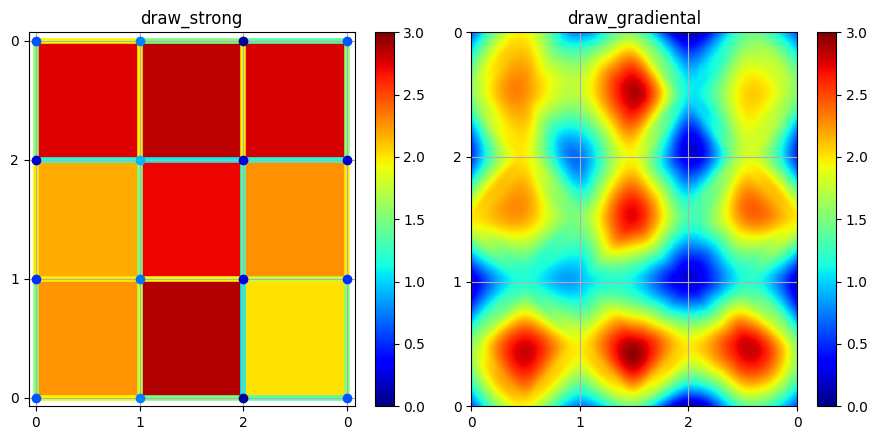

In [3]:
shape = 3, 3

ctc = CubicalTorusComplex(shape)
ctc.assign_random_barycentric_filtration()

if len(shape) == 2:
    fig, axs = plt.subplots(1, 2, figsize=(9, 4.5))

    axs[0].set_title('draw_strong')
    sm0 = ctc.draw_strong(ax=axs[0], vmin=0, vmax=len(shape) + 1)
    axs[1].set_title('draw_gradiental')
    sm1 = ctc.draw_gradiental(ax=axs[1], vmin=0, vmax=len(shape) + 1)

    for i in range(2):
        axs[i].set_xticks(np.arange(shape[0] + 1), labels=np.arange(shape[0] + 1)%shape[0])
        axs[i].set_yticks(np.arange(shape[1] + 1), labels=np.arange(shape[1] + 1)%shape[1])
        axs[i].grid(True)

    eps = 0.07
    axs[0].set_xlim(0 - eps, shape[0] + eps)
    axs[0].set_ylim(0 - eps, shape[1] + eps)

    plt.colorbar(sm0, ax=axs[0])
    plt.colorbar(sm1, ax=axs[1])
    plt.tight_layout()
    plt.show()


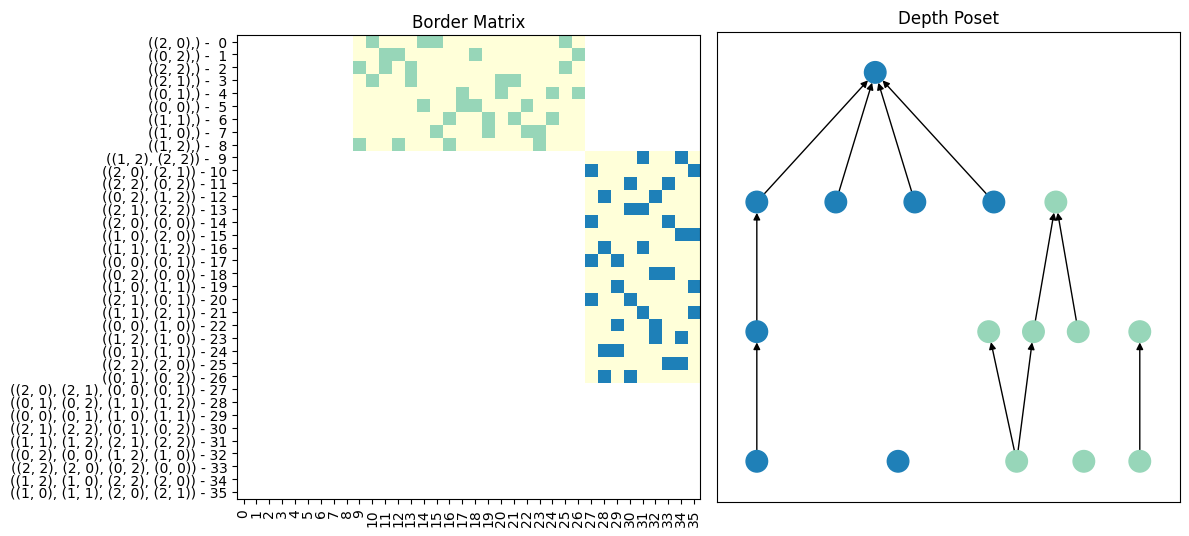

In [4]:
sort_with_filtration = True

order, dims, fvals = ctc.get_order(sort_with_filtration=sort_with_filtration, return_dims=True, return_filtration=True)
bm = ctc.get_border_matrix(sort_with_filtration=sort_with_filtration)
dp = ctc.get_depth_poset(sort_with_filtration=sort_with_filtration)

bm_show = bm.astype(float)*dims
bm_show[dims.reshape(-1, 1) - dims.reshape(1, -1) != -1] = np.nan





fig, axs = plt.subplots(1, 2, figsize=(12, 5.5))
cmap = plt.get_cmap('YlGnBu')

axs[0].set_title('Border Matrix')
axs[0].imshow(bm_show, cmap=cmap, vmax=3)
axs[0].set_yticks(np.arange(len(order)), [f'{val} -{i:>3}' for i, val in enumerate(order)], rotation=0)
axs[0].set_xticks(np.arange(len(order)), np.arange(len(order)), rotation=90)

axs[1].set_title('Depth Poset')
g = dp.get_transitive_reduction()
pos = {node: (x, -y) for node, (x, y) in nx.nx_agraph.graphviz_layout(g, prog="dot", args='-Grankdir=DU').items()}
nx.draw_networkx(g, pos=pos, node_color=[cmap((node.dim + 1)/(ctc.dim + 1)) for node in dp.nodes], node_size=240,
                 with_labels=False, ax=axs[1])

plt.tight_layout()
plt.show()

# Poset Scores

In [5]:
df_poset_scores = {}

for name, score in inspect.getmembers(poset_scores, inspect.isfunction):
    df_poset_scores.update({name: {'full': score(dp), 
                                   'subposet dim 0': score(dp.subposet_dim(0)), 
                                   'subposet dim 1': score(dp.subposet_dim(1)), 
                            }})

df_poset_scores = pd.DataFrame(df_poset_scores).transpose()
df_poset_scores

,full,subposet dim 0,subposet dim 1
avarage_maximal_chain,2.1,2.0,2.2
cycles_dimension,0.0,0.0,0.0
height,3.0,2.0,3.0
minimum_maximal_chain,1.0,1.0,1.0
number_of_components,5.0,3.0,2.0
number_of_edges_in_closure,15.0,6.0,9.0
number_of_edges_in_reduction,11.0,5.0,6.0
number_of_maximal_nodes,6.0,4.0,2.0
number_of_minimal_nodes,9.0,4.0,5.0
number_of_nodes,16.0,8.0,8.0


In [6]:
df_node_scores = {}

for name, score in inspect.getmembers(node_scores, inspect.isfunction):
    df_node_scores.update({name: {'full': [score(dp, node) for node in dp.nodes],
                                  'subposet dim 0': [score(dp.subposet_dim(0), node) for node in dp.subposet_dim(0).nodes], 
                                  'subposet dim 1': [score(dp.subposet_dim(1), node) for node in dp.subposet_dim(1).nodes],
                            }})

df_node_scores = pd.DataFrame(df_node_scores).transpose()

df_node_scores.applymap(np.mean)

/tmp/ipykernel_45704/1981805424.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_node_scores.applymap(np.mean)


,full,subposet dim 0,subposet dim 1
ancestors_cycles_dimension,0.0000,0.000,0.000
ancestors_height,0.2500,0.125,0.375
ancestors_number,0.9375,0.750,1.125
ancestors_width,0.6875,0.625,0.750
incomparable_number,13.1250,5.500,4.750
successors_cycles_dimension,0.0000,0.000,0.000
successors_height,0.2500,0.125,0.375
successors_number,0.9375,0.750,1.125
successors_width,0.6875,0.625,0.750


# Compare 2 complexes

## Define complexes

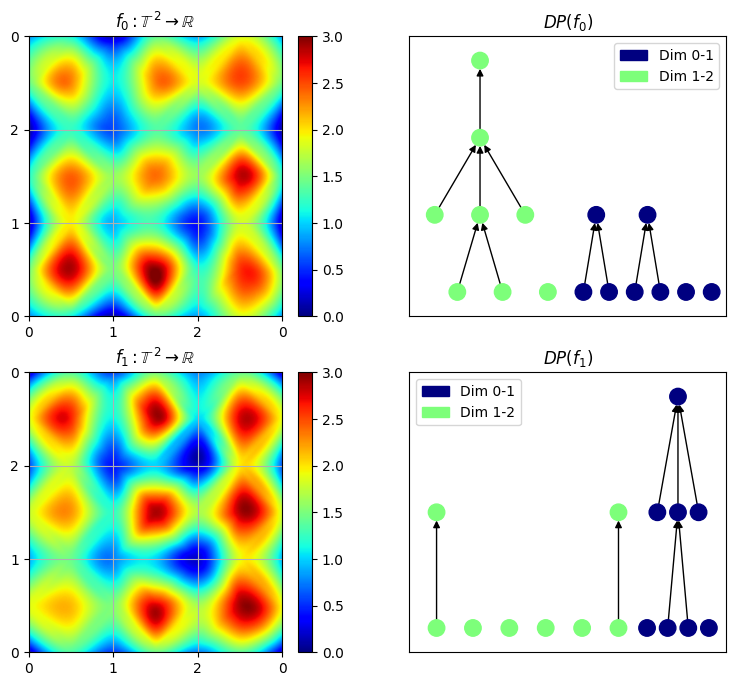

In [7]:
shape = 3, 3

ctc0 = CubicalTorusComplex(shape)
ctc0.assign_random_barycentric_filtration()

ctc1 = CubicalTorusComplex(shape)
ctc1.assign_random_barycentric_filtration()

fvals0 = ctc0.filtration_values
fvals1 = ctc1.filtration_values

t = 0.0
fvals0_new = [m0*(1 - t) + m1*t for m0, m1 in zip(fvals0, fvals1)]
fvals1_new = [m0*t + m1*(1 - t) for m0, m1 in zip(fvals0, fvals1)]
ctc0.assign_filtration(fvals0_new)
ctc1.assign_filtration(fvals1_new)

dp0 = ctc0.get_depth_poset()
dp1 = ctc1.get_depth_poset()

fig, axs = plt.subplots(2, 2, figsize=(9, 8))

cmap_filtration = plt.get_cmap('jet')
cmap_dimensions = plt.get_cmap('jet')
for i, (ctc, dp) in enumerate([(ctc0, dp0), (ctc1, dp1)]):
    axs[i, 0].set_title(f'$f_{i}:\\mathbb{{T}}\\;^{{{len(shape)}}} \\to \\mathbb{{R}}$')
    sm = ctc.draw_gradiental(ax=axs[i, 0], cmap=cmap_filtration, vmin=0, vmax=len(shape) + 1)
    plt.colorbar(sm, ax=axs[i, 0])
    
    axs[i, 0].set_xticks(np.arange(shape[0] + 1), labels=np.arange(shape[0] + 1)%shape[0])
    axs[i, 0].set_yticks(np.arange(shape[1] + 1), labels=np.arange(shape[1] + 1)%shape[1])
    axs[i, 0].grid(True)
    
    
    axs[i, 1].set_title(f'$DP(f_{i})$')
    g = dp.get_transitive_reduction()
    pos = {node: (x, -y) for node, (x, y) in nx.nx_agraph.graphviz_layout(g, prog="dot", args='-Grankdir=DU').items()}
    nx.draw_networkx(g, pos=pos, node_color=[cmap_dimensions(node.dim/ctc.dim) for node in dp.nodes], node_size=140,
                    with_labels=False, ax=axs[i, 1])
    handles = [mpatches.Patch(color=cmap_dimensions(dim/ctc.dim), label=f"Dim {dim}-{dim + 1}") for dim in range(ctc.dim)]
    axs[i, 1].legend(handles=handles, title=None, loc="best")


## Similarity

In [8]:
sim_scores = [f for _, f in inspect.getmembers(depth_poset_similarity_scores, inspect.isfunction) if inspect.getmodule(f) == depth_poset_similarity_scores]

df_sim = pd.Series({(score.__name__.replace('cell', '').replace('index', '').replace('__', '_'), score.__name__.find('cell') != -1): score(dp0, dp1) for score in sim_scores})
df_sim = df_sim.unstack(level=1).rename(columns={False: 'by indices', True: 'by cells'})
df_sim

,by indices,by cells
birth_relation_similarity,0.0,0.000000
death_relation_similarity,0.0,0.000000
poset_arc_similarity,0.0,0.000000
poset_node_similarity,0.0,0.103448
relation_similarity,0.0,0.000000


## Linear Homotopy

## Cross parameters

In [9]:
def get_cross_parameters(y0, y1, t0=0, t1=1, filter_outside=True):
    """
    Returns the matrix of cross parameters between two arrays.

    Parameters:
        y0, y1: two arrays of the same length
        t0, t1: the time points for the arrays
        filter_outside: if True, filter out the values outside the range [t0, t1]

    Returns:
        cross_parameters: the matrix of cross parameters
    """
    y0 = np.asarray(y0)
    y1 = np.asarray(y1)
    if y0.shape != y1.shape:
        raise ValueError("Arrays must have the same length.")
    if y0.ndim != 1:
        raise ValueError("Arrays must be 1D.")
    
    yi0 = y0.reshape(-1, 1)
    yi1 = y1.reshape(-1, 1)
    yj0 = y0.reshape(1, -1)
    yj1 = y1.reshape(1, -1)

    cross_parameters = (t1 - t0)*(yj0 - yi0)/(yi1 - yi0 - yj1 + yj0) + t0


    if filter_outside:
        cross_parameters[cross_parameters < min(t0, t1)] = np.nan
        cross_parameters[cross_parameters > max(t0, t1)] = np.nan
    return cross_parameters

/tmp/ipykernel_45704/49407725.py:25: RuntimeWarning: invalid value encountered in divide
  cross_parameters = (t1 - t0)*(yj0 - yi0)/(yi1 - yi0 - yj1 + yj0) + t0


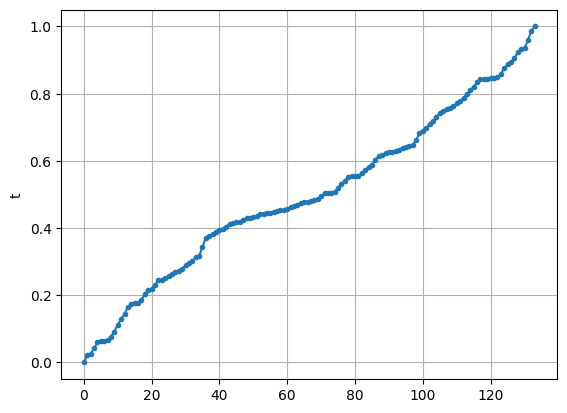

In [10]:
cross_parameters = [get_cross_parameters(m0.flatten(), m1.flatten()) for m0, m1 in zip(fvals0, fvals1)]
#cross_parameters = [m0.flatten()*(1 - t) + m1.flatten()*t for m0, m1, t in zip(fvals0, fvals1, cross_parameters)]
cross_parameters = np.unique(np.concatenate([m.flatten() for m in cross_parameters]))
cross_parameters = np.sort(cross_parameters[~np.isnan(cross_parameters)])

ts = np.unique(np.concatenate([0.5*(cross_parameters[1:] + cross_parameters[:-1]), [0, 1]]))

plt.plot(ts, marker='.')
plt.grid(True)
plt.ylabel('t')
plt.show()

## Similarity Scores

In [11]:
fvals0 = ctc0.filtration_values
fvals1 = ctc1.filtration_values

#ts = np.linspace(0, 1, 11)

ctcs = []
for t in ts:
    fvals_new = [m0*(1 - t) + m1*t for m0, m1 in zip(fvals0, fvals1)]
    
    ctc = CubicalTorusComplex(shape)
    ctc.assign_filtration(fvals_new)
    ctc.assign_random_barycentric_filtration()
    ctcs.append(ctc)

dps = [ctc.get_depth_poset() for ctc in ctcs]



In [12]:
similarity_matrices = {score.__name__: np.array([[score(dp0, dp1) for dp1 in dps] for dp0 in dps]) for score in tqdm(sim_scores)}

  0%|          | 0/10 [00:00<?, ?it/s]

In [13]:
def get_diff_array(matrix, diff=0):
    # 
    m0 = np.ones(matrix.shape) * np.arange(matrix.shape[0])
    m1 = np.ones(matrix.shape) * np.arange(matrix.shape[1]).reshape(-1, 1)
    diff_array = matrix[m1 - m0 == diff]
    return diff_array

diff_range = np.arange(0, list(similarity_matrices.values())[0].shape[0])

df_diffs = pd.DataFrame(
    {
    (key, f.__name__): [f(get_diff_array(matrix, diff_val)) for diff_val in diff_range] for (key, matrix), f in itertools.product(similarity_matrices.items(), [np.mean, 
                                                                                                                                                                np.max, 
                                                                                                                                                                #np.min, 
                                                                                                                                                                ])
    }, index=diff_range,
)
print(f'df_diffs.shape = {df_diffs.shape}')
df_diffs.head()

df_diffs.shape = (134, 20)


birth_relation_cell_similarity           birth_relation_index_similarity  \
                            mean       max                            mean   
0                       1.000000  1.000000                        1.000000   
1                       0.002863  0.090909                        0.003026   
2                       0.002028  0.083333                        0.002755   
3                       0.004723  0.125000                        0.002745   
4                       0.001894  0.071429                        0.003014   

            death_relation_cell_similarity            \
        max                           mean       max   
0  1.000000                       1.000000  1.000000   
1  0.071429                       0.002249  0.083333   
2  0.083333                       0.002492  0.090909   
3  0.090909                       0.003624  0.071429   
4  0.076923                       0.003747  0.181818   

  death_relation_index_similarity           poset_arc_cell_similarity  \
                             mean       max                      mean   
0                        1.000000  1.000000                  1.000000   
1                        0.002078  0.076923                  0.002064   
2                        0.003565  0.105263                  0.001572   
3                        0.003971  0.095238                  0.003184   
4                        0.001931  0.142857                  0.002167   

            poset_arc_index_similarity           poset_node_cell_similarity  \
        max                       mean       max                       mean   
0  1.000000                   1.000000  1.000000                   1.000000   
1  0.045455                   0.004586  0.074074                   0.079206   
2  0.035714                   0.006934  0.121951                   0.075954   
3  0.052632                   0.005845  0.115385                   0.089090   
4  0.085714                   0.004836  0.156250                   0.079100   

            poset_node_index_similarity           relation_cell_similarity  \
        max                        mean       max                     mean   
0  1.000000                    1.000000  1.000000                 1.000000   
1  0.230769                    0.064124  0.333333                 0.002635   
2  0.280000                    0.068172  0.280000                 0.001833   
3  0.280000                    0.072588  0.391304                 0.003734   
4  0.230769                    0.057467  0.333333                 0.002634   

            relation_index_similarity            
        max                      mean       max  
0  1.000000                  1.000000  1.000000  
1  0.050000                  0.003334  0.083333  
2  0.050000                  0.005927  0.096774  
3  0.066667                  0.004881  0.100000  
4  0.100000                  0.003308  0.136364

In [14]:
df_diffs.columns.get_level_values(0).nunique()

10

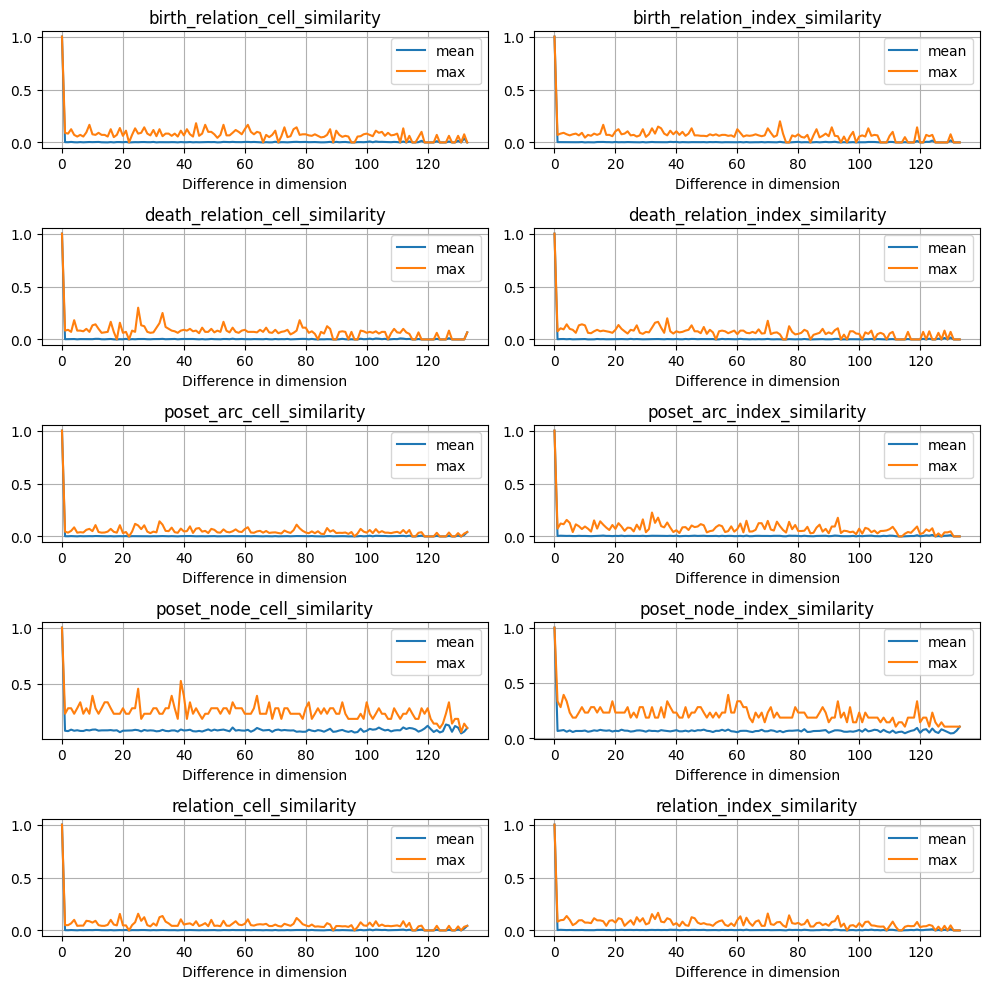

,max,mean
birth_relation_cell_similarity,-0.331975,-0.139668
birth_relation_index_similarity,-0.350863,-0.148349
death_relation_cell_similarity,-0.390920,-0.141852
death_relation_index_similarity,-0.402101,-0.150396
poset_arc_cell_similarity,-0.285932,-0.140257
poset_arc_index_similarity,-0.364114,-0.151823
poset_node_cell_similarity,-0.410519,-0.112744
poset_node_index_similarity,-0.495219,-0.156771
relation_cell_similarity,-0.311482,-0.139748
relation_index_similarity,-0.366241,-0.151250


In [15]:
fig, axs = plt.subplots(df_diffs.columns.get_level_values(0).nunique() // 2, 2, figsize=(10, df_diffs.columns.get_level_values(0).nunique()))
for i, col in enumerate(df_diffs.columns.get_level_values(0).unique()):
    ax = axs[i//2, i%2]
    df_diffs[col].plot(ax=ax)
    ax.set_title(col)
    ax.set_xlabel('Difference in dimension')
    ax.grid(True)
plt.tight_layout()
plt.show()

index_series = pd.Series(df_diffs.index, name="index", index=df_diffs.index)
df_diffs.apply(lambda col: col.corr(index_series)).unstack()


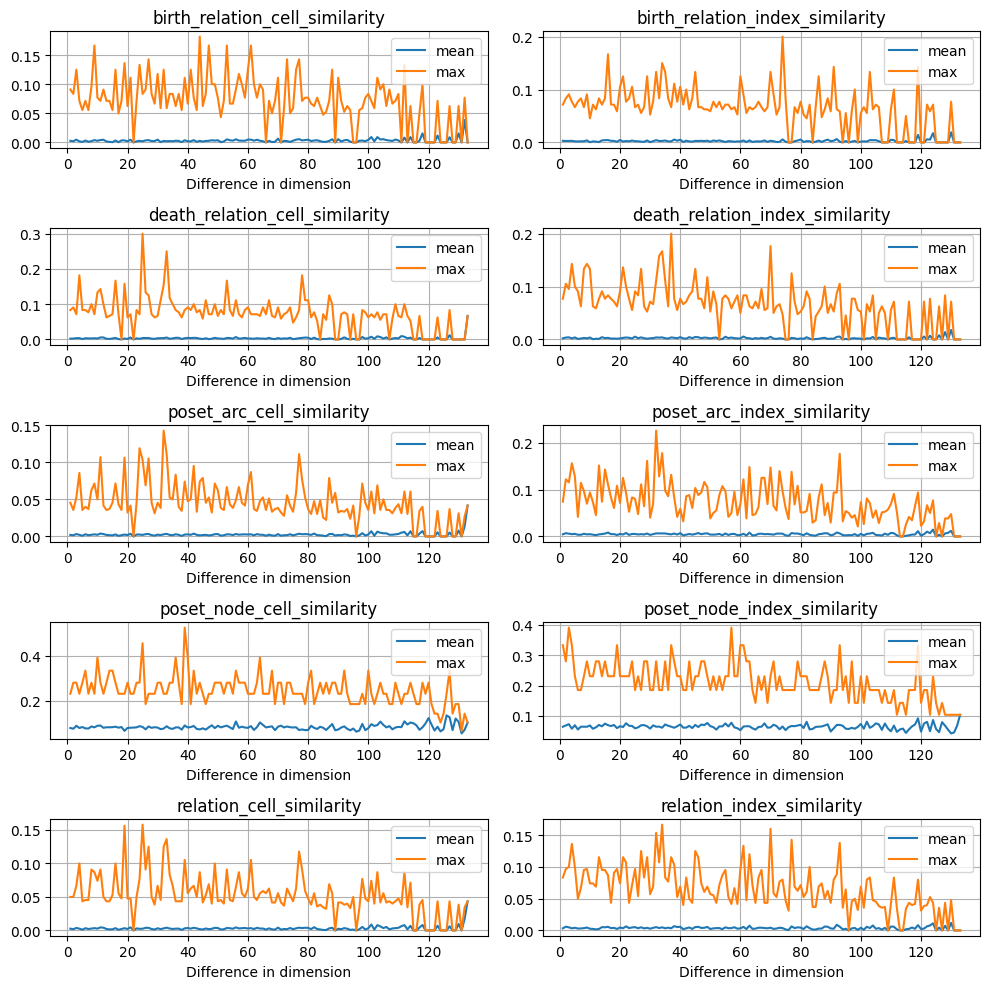

,max,mean
birth_relation_cell_similarity,-0.436580,0.197539
birth_relation_index_similarity,-0.495212,0.020685
death_relation_cell_similarity,-0.516958,0.101056
death_relation_index_similarity,-0.599353,-0.051708
poset_arc_cell_similarity,-0.474126,0.196137
poset_arc_index_similarity,-0.512044,-0.103691
poset_node_cell_similarity,-0.438623,0.230595
poset_node_index_similarity,-0.579008,-0.078971
relation_cell_similarity,-0.497371,0.191315
relation_index_similarity,-0.582032,-0.091612


In [16]:
df_diffs1 = df_diffs.loc[df_diffs.index != 0, :].copy()

fig, axs = plt.subplots(df_diffs1.columns.get_level_values(0).nunique() // 2, 2, figsize=(10, df_diffs1.columns.get_level_values(0).nunique()))
for i, col in enumerate(df_diffs1.columns.get_level_values(0).unique()):
    ax = axs[i//2, i%2]
    df_diffs1[col].plot(ax=ax)
    ax.set_title(col)
    ax.set_xlabel('Difference in dimension')
    ax.grid(True)
plt.tight_layout()
plt.show()

index_series = pd.Series(df_diffs1.index, name="index", index=df_diffs1.index)
df_diffs1.apply(lambda col: col.corr(index_series)).unstack()


## Gif-Image

## Transpositions

In [29]:
cross_parameters = [get_cross_parameters(m0.flatten(), m1.flatten()).reshape(m0.shape + m1.shape) for m0, m1 in zip(fvals0, fvals1)]

eps = np.concatenate([i.flatten() for i in cross_parameters])
eps = eps[~np.isnan(eps)]
eps = np.unique(np.concatenate([eps, [0, 1]]))
eps = 0.8*(eps[1:] - eps[:-1]).min()


df_transpositions = []


for dim, (parameters, m0, m1) in enumerate(zip(cross_parameters, fvals0, fvals1)):
    # flat parameters
    
    for i in np.argwhere(~np.isnan(parameters)):
        i0 = tuple(i[:len(i) // 2])
        i1 = tuple(i[len(i) // 2:])

        t = parameters[i0 + i1]
        value = m0[i0]*(1 - t) + m1[i0]*t
        df_transpositions.append({'i0': i0, 'i1': i1, 't': t, 'dim': dim, 'value': value})

df_transpositions = pd.DataFrame(df_transpositions)

def get_flat_index(coords, dim, shape, add=True):
    """
    Преобразует многомерный индекс в плоский.
    """
    poly_shape = (math.comb(len(shape), dim), ) + shape
    flat_index = np.ravel_multi_index(coords, poly_shape)
    if add:
        flat_index += int(np.sum([math.comb(len(shape), i) for i in range(dim)])*np.prod(shape))
    return flat_index
df_transpositions['index0'] = df_transpositions.apply(lambda row: get_flat_index(row['i0'], row['dim'], shape), axis=1)
df_transpositions['index1'] = df_transpositions.apply(lambda row: get_flat_index(row['i1'], row['dim'], shape), axis=1)

order = ctc0.get_order(sort_with_filtration=False)
df_transpositions['cell0'] = df_transpositions['index0'].apply(lambda i: order[i])
df_transpositions['cell1'] = df_transpositions['index1'].apply(lambda i: order[i])


df_transpositions['hash'] = df_transpositions.apply(lambda row: (row['dim'], row['i0'], row['i1']) if row['i0'] < row['i1'] else (row['dim'], row['i1'], row['i0']), axis=1)
assert 2*df_transpositions['hash'].nunique() == len(df_transpositions)
assert (df_transpositions.groupby('hash').count() == 2).all().all()
assert df_transpositions.groupby('hash')['t'].apply(lambda x: len(np.unique(np.array(x).round(8))) == 1).all()
assert df_transpositions.groupby('hash')['value'].apply(lambda x: len(np.unique(np.array(x).round(8))) == 1).all()

df_transpositions = df_transpositions.loc[df_transpositions['hash'].drop_duplicates().index]
df_transpositions = df_transpositions.sort_values(['dim', 'value']).reset_index(drop=True)
df_transpositions = df_transpositions.drop(columns='hash')

df_transpositions['complex'] = df_transpositions.apply(lambda row: CubicalTorusComplex(shape).assign_filtration([m0*(1 - (row['t'] - eps)) + m1*(row['t'] - eps) for m0, m1 in zip(fvals0, fvals1)]), axis=1)
df_transpositions['order&dims'] = df_transpositions['complex'].apply(lambda x: x.get_order(sort_with_filtration=True, return_filtration=False, return_dims=True))
df_transpositions['order'] = df_transpositions['order&dims'].apply(lambda x: x[0])
df_transpositions['dims'] = df_transpositions['order&dims'].apply(lambda x: x[1])
df_transpositions = df_transpositions.drop(columns='order&dims')

df_transpositions['order_i0'] = df_transpositions.apply(lambda row: row['order'].index(row['cell0']), axis=1)
df_transpositions['order_i1'] = df_transpositions.apply(lambda row: row['order'].index(row['cell1']), axis=1)

to_reverse = df_transpositions['order_i1'] - df_transpositions['order_i0'] == -1
i0_vals = df_transpositions.loc[to_reverse, 'order_i0']
i1_vals = df_transpositions.loc[to_reverse, 'order_i1']
df_transpositions.loc[to_reverse, 'order_i0'] = i1_vals
df_transpositions.loc[to_reverse, 'order_i1'] = i0_vals


df_transpositions['border matrix'] = df_transpositions['complex'].apply(lambda x: x.get_border_matrix(sort_with_filtration=True))
df_transpositions['dp'] = df_transpositions['complex'].apply(lambda x: x.get_depth_poset(sort_with_filtration=True))

df_transpositions['transposition'] = df_transpositions.apply(
    lambda row: 
    Transposition(border_matrix=row['border matrix'], 
                  index0=row['order_i0'], 
                  index1=row['order_i1'], 
                  order=row['order'], 
                  dims=row['dims'], 
                  dp=row['dp']), 
    axis=1
)

df_transpositions = df_transpositions.drop(columns=['i0', 'i1', 'index0', 'index1', 'cell0', 'cell1', 'order_i0', 'order_i1', 'dim'])

df_transpositions = pd.concat([pd.DataFrame(df_transpositions['transposition'].apply(lambda tr: tr.to_dict()).to_list(), index=df_transpositions.index), 
                               df_transpositions], axis=1)


print(f'\ndf_transpositions.shape = {df_transpositions.shape}')
df_transpositions.head()

/tmp/ipykernel_45704/49407725.py:25: RuntimeWarning: invalid value encountered in divide
  cross_parameters = (t1 - t0)*(yj0 - yi0)/(yi1 - yi0 - yj1 + yj0) + t0


self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
self.index1 - self.index0 != 1

df_tran

,index 0,index 1,cell 0,cell 1,dim,type,switch,t,value,complex,order,dims,border matrix,dp,transposition
0,1,2,"((2, 1),)","((2, 2),)",0,birth-birth,switch forward,0.934629,0.228045,<src.complexes.CubicalTorusComplex object at 0...,"[((0, 0),), ((2, 1),), ((2, 2),), ((1, 1),), (...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...",<src.depth.DepthPoset object at 0x7fc5476ea420>,"<((2, 1),), ((2, 2),)>"
1,0,1,"((0, 0),)","((2, 2),)",0,birth-unpaired,undefined,0.895729,0.235760,<src.complexes.CubicalTorusComplex object at 0...,"[((0, 0),), ((2, 2),), ((2, 1),), ((1, 1),), (...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...",<src.depth.DepthPoset object at 0x7fc5571d46e0>,"<((0, 0),), ((2, 2),)>"
2,0,1,"((0, 1),)","((2, 2),)",0,birth-unpaired,undefined,0.458863,0.322403,<src.complexes.CubicalTorusComplex object at 0...,"[((0, 1),), ((2, 2),), ((1, 0),), ((2, 1),), (...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",<src.depth.DepthPoset object at 0x7fc5476e9310>,"<((0, 1),), ((2, 2),)>"
3,1,2,"((1, 0),)","((2, 2),)",0,birth-birth,switch forward,0.431741,0.327782,<src.complexes.CubicalTorusComplex object at 0...,"[((0, 1),), ((1, 0),), ((2, 2),), ((0, 2),), (...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",<src.depth.DepthPoset object at 0x7fc5476ea180>,"<((1, 0),), ((2, 2),)>"
4,1,2,"((0, 0),)","((2, 1),)",0,birth-birth,switch backward,0.750722,0.329692,<src.complexes.CubicalTorusComplex object at 0...,"[((2, 2),), ((0, 0),), ((2, 1),), ((1, 0),), (...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...",<src.depth.DepthPoset object at 0x7fc5476e8230>,"<((0, 0),), ((2, 1),)>"


In [30]:
(df_transpositions['index 1'] - df_transpositions['index 0']).value_counts()

1    113
Name: count, dtype: int64

In [34]:
df_transpositions[['dim', 'type', 'switch']].value_counts().reset_index().pivot_table(columns=['switch'], index=['dim', 'type'], values='count').fillna(0).astype(int)

switch                 no switch  switch backward  switch forward  undefined
dim type                                                                    
0   birth-birth               15                1               3          0
    birth-unpaired             0                0               0          2
1   birth-birth               16                0               0          0
    birth-death                7                0               1          0
    birth-unpaired             0                0               0         18
    death-death               18                1               1          0
    death-unpaired             0                0               0          8
    unpaired-unpaired          0                0               0          2
2   death-death               17                1               0          0
    death-unpaired             0                0               0          2